In [89]:
import numpy as np
import pysindy as ps

from scipy.integrate import solve_ivp
from pysindy.utils import linear_damped_SHO, cubic_damped_SHO, van_der_pol, lotka

import matplotlib.pyplot as plt

from numpy import genfromtxt

import deepSI
from deepSI import System_data

import torch
from torch import nn
from torch.nn import functional as F

import csv
import os

from scipy.io import loadmat

In [90]:
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

# training data
dt = 0.01
t_train = np.arange(0, 50, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [2, 0]
x_train = solve_ivp(van_der_pol, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T

# training data
t_test = np.arange(0, 25, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = [0.1, 0.5]
x_test = solve_ivp(van_der_pol, t_test_span,
                    x0_test, t_eval=t_test, **integrator_keywords).y.T

u_train = None
u_test = None

In [91]:
# # data dir and file
# save_dir = r"C:\Users\20173928\OneDrive - TU Eindhoven\Documents\Master\thesis\mscth\data"

# out = loadmat(os.path.join(save_dir,'Silverbox_full_state_low_error.mat'))
# x_data = out['xOptTot']

# save_dir = r"C:\Users\20173928\OneDrive - TU Eindhoven\Documents\Master\thesis\mscth\data"
# out = loadmat(os.path.join(save_dir,'Silverbox_u_upsampled.mat'))
# u = out['u']

# dt =1

In [92]:
def normalize(y):
  y_mu = np.mean(y)
  y_std = np.std(y)
  y_norm = (y-y_mu)/y_std

  return y_norm, y_std, y_mu

In [93]:
# generate function set
x_train, x_std, x_mu = normalize(x_train)

degree = 3

feature_library=ps.PolynomialLibrary(degree=degree)

# train
train_x = x_train[:-1,:]
Theta = torch.as_tensor(np.array(feature_library.fit(train_x).transform(train_x))).to(torch.float32)

if u_train is not None:
  target_x = torch.as_tensor(x_train[1:,:-1]).to(torch.float32)
else:
  target_x = torch.as_tensor(x_train[1:,:]).to(torch.float32)

# test
test_x = x_test[:-1,:]
Theta_test = torch.as_tensor(np.array(feature_library.fit(test_x).transform(test_x))).to(torch.float32)
if u_test is not None:
  target_x_test = torch.as_tensor(x_test[1:,:-1]).to(torch.float32)
else:  
  target_x_test = torch.as_tensor(x_test[1:,:]).to(torch.float32)

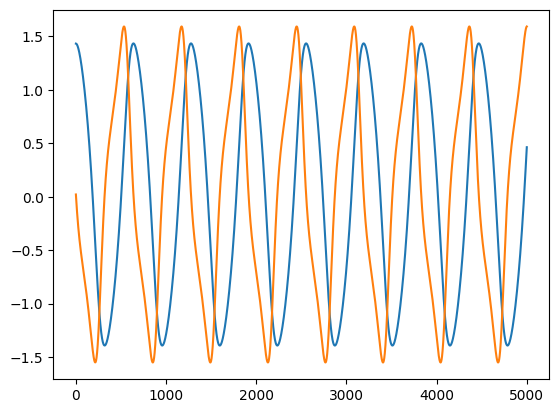

In [94]:
plt.plot(x_train)

In [95]:
import torch
from torch import nn
from torch.nn import functional as F

class MLP(torch.nn.Module):
    def __init__(self, n_in, n_out):#, threshold=0):
        super(MLP, self).__init__()
        
        self.layer = nn.Linear(n_in, n_out, bias=False)# if threshold==0 else PruningLinear(n_in, n_out, threshold)
        # self.layer = 

    def forward(self, x):
        out = self.layer(x)
        return out
    
# class PruningLinear(torch.nn.Linear):
#     def __init__(self, in_features, out_features, threshold, **kwargs):
#         super(PruningLinear, self).__init__(in_features, out_features, **kwargs)
#         self.threshold = threshold

#     def forward(self, input):
#         weight = self.weight.clone()
#         weight[torch.abs(weight) < self.threshold] = 0
#         self.weight = nn.Parameter(weight)
#         return F.linear(input, self.weight, self.bias)
    
def prune_weights(model, threshold=1e-6):
    for name, param in model.named_parameters():
        if 'weight' in name:
            param.data[param.data.abs() < threshold] = 0

In [96]:
n_in = Theta.shape[-1]
n_out = target_x.shape[-1]

model = MLP(n_in, n_out)

In [97]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [98]:
def SINDyLoss(X, Theta, Xi, l):
    # reg_loss = torch.sum(1/(X.shape[0]) * torch.sqrt((X-torch.matmul(Theta,torch.transpose(Xi,0,1)))**2)**2)
    reg_loss = 1/X.shape[0] *torch.sum(torch.abs(X-torch.matmul(Theta,torch.transpose(Xi,0,1)))**2)
    l1_loss = l**2*torch.sum(torch.abs(Xi))
    return reg_loss, l1_loss

def SINDyLoss2(X_pred, X_true, Theta, Xi, l):
    params = [x.view(-1) for x in Xi]
    l1_params = torch.cat(params)
    Xi = Xi[0]
    reg_loss = 1/X_true.shape[0] *torch.sum(torch.abs(X_true-torch.matmul(Theta,torch.transpose(Xi,0,1)))**2)
    pred_loss = 1/X_true.shape[0] *torch.sum(torch.abs(X_true-X_pred)**2)
    l1_loss = l*torch.norm(l1_params, 1)
    return reg_loss, pred_loss, l1_loss

In [99]:
epochs = 5000

lambda_1 = 0

batch_size = 256
n_batches = Theta.shape[0]//batch_size

losses = []

for epo in range(epochs):
    for batch in range(n_batches):
        Theta_b    = Theta[batch*batch_size:batch*batch_size+batch_size,:]
        target_x_b = target_x[batch*batch_size:batch*batch_size+batch_size,:]

        optimizer.zero_grad()
        output = model(Theta_b)

        # loss
        Xi = [*model.parameters()]
        
        # if epo>(epochs*1/4) and epo<(epochs*19/20):
        #     lambda_1 = 0.05
        # elif epo>(epochs*19/20):
        #     lambda_1 = 0
        #     prune_weights(model, threshold=1e-6)

        reg, pred, l1 = SINDyLoss2(output, target_x_b, Theta_b, Xi, lambda_1)
        loss = reg+l1+pred
        losses.append(loss.detach().numpy())

        loss.backward()

        optimizer.step()

    if (epo%(epochs//10)==0 or epo==epochs-1) and epo != 0:
        epo_p = epo if epo != epochs-1 else epo+1
        print("Epoch {} train loss: {:.10f}".format(epo_p, loss))
        print("reg loss {:.4f}, pred loss {:.4f}, l1 loss: {:.4f}".format(reg, pred, l1))

Epoch 500 train loss: 0.0170864034
reg loss 0.0085, pred loss 0.0085, l1 loss: 0.0000
Epoch 1000 train loss: 0.0047394042
reg loss 0.0024, pred loss 0.0024, l1 loss: 0.0000
Epoch 1500 train loss: 0.0026433568
reg loss 0.0013, pred loss 0.0013, l1 loss: 0.0000
Epoch 2000 train loss: 0.0010823675
reg loss 0.0005, pred loss 0.0005, l1 loss: 0.0000
Epoch 2500 train loss: 0.0003399311
reg loss 0.0002, pred loss 0.0002, l1 loss: 0.0000
Epoch 3000 train loss: 0.0000306648
reg loss 0.0000, pred loss 0.0000, l1 loss: 0.0000
Epoch 3500 train loss: 0.0000000001
reg loss 0.0000, pred loss 0.0000, l1 loss: 0.0000
Epoch 4000 train loss: 0.0000000251
reg loss 0.0000, pred loss 0.0000, l1 loss: 0.0000
Epoch 4500 train loss: 0.0000000253
reg loss 0.0000, pred loss 0.0000, l1 loss: 0.0000
Epoch 5000 train loss: 0.0000000154
reg loss 0.0000, pred loss 0.0000, l1 loss: 0.0000


In [100]:
# test_pred = model(Theta_test).detach().numpy()
# test_true = target_x_test.detach().numpy()
# np.sum(np.abs(test_pred-test_true), axis=0)/test_pred.shape[0]


In [101]:
# the_model = MLP(n_in, n_out)
# the_model.load_state_dict(torch.load("test"))

In [102]:
threshold = 0
params = [x.detach().numpy() for x in model.parameters()][0]

NN_p_1 = params[0, np.abs(params[0,:]) > threshold]
NN_p_2 = params[1, np.abs(params[1,:]) > threshold]
NN_p = [NN_p_1, NN_p_2]

In [103]:
params = [x.detach().numpy() for x in model.parameters()][0]
params

array([[-1.8720503e-04,  9.9995053e-01,  1.0032416e-02,  1.1670762e-05,
         3.0880256e-07,  2.9605575e-05,  3.5947141e-06, -4.8734728e-05,
        -5.6235331e-06,  7.6853867e-06],
       [ 1.1793128e-04, -9.8353596e-03,  1.0049471e+00,  2.1987449e-04,
         4.0069374e-04,  2.3111004e-05, -4.9119899e-05, -9.9699739e-03,
        -2.0481138e-04,  2.4522551e-06]], dtype=float32)

In [104]:
# feature_library=ps.PolynomialLibrary(degree=degree)

s_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=8e-3),
    feature_library=feature_library,
    discrete_time=True
)
if u_train is not None:
    s_model.fit(x_train[:,:-1], u=u_train, t=dt)
else:
    s_model.fit(x_train, t=dt)
s_model.print(precision=5)


# plt.plot(x_train[0:2500])
# plt.plot(x_train[0:2500,:]-model.simulate(x_train[0],t=2500))

(x0)[k+1] = 0.99995 x0[k] + 0.01000 x1[k]
(x1)[k+1] = -0.01000 x0[k] + 1.00492 x1[k] + -0.01001 x0[k]^2 x1[k]


In [105]:
# coeff = s_model.coefficients()

# S_p_1 = coeff[0, np.abs(coeff[0,:]) > threshold]
# S_p_2 = coeff[1, np.abs(coeff[1,:]) > threshold]
# S_p = [S_p_1, S_p_2]

In [106]:
# true coeff VPOl
# x1_true = [0, 0, 1]
# x2_true = [0, 1, 0.5, 0.5]

# true coeff L SHO
x1_true = [0, 1, 0.01,0,0,0,0,0,0]
x2_true = [0,0.01, 1,0,0,0,0,0.01]

In [107]:
function_names = feature_library.get_feature_names()

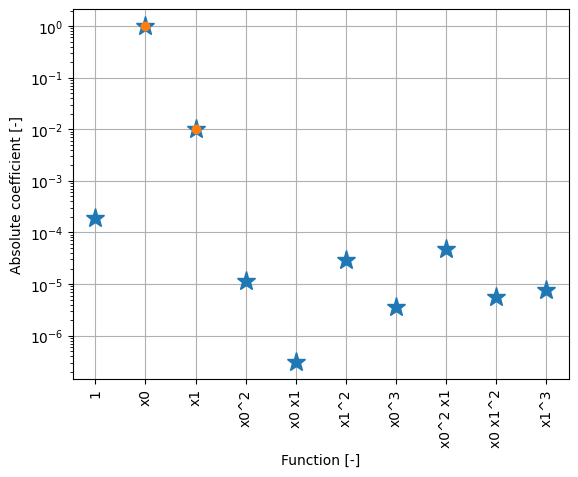

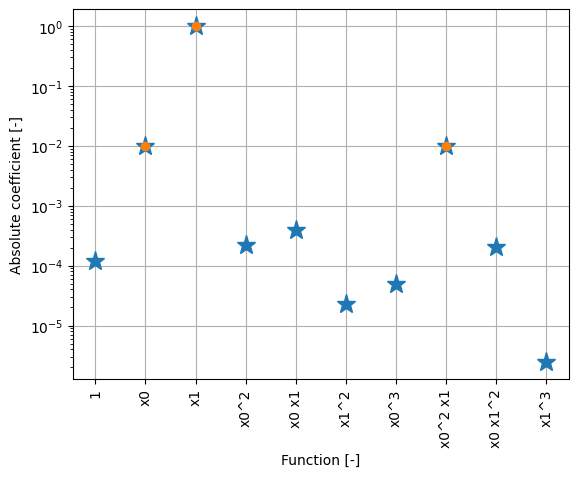

In [108]:
plt.semilogy(np.abs(NN_p[0]),"*", markersize=14)
plt.semilogy(x1_true,"o")
plt.xticks(np.arange(NN_p[0].shape[0]), function_names, rotation=90)
plt.xlabel("Function [-]")
plt.ylabel("Absolute coefficient [-]")
plt.grid()
plt.show()

plt.semilogy(np.abs(NN_p[1]),"*", markersize=14)
plt.semilogy(x2_true,"o")
plt.xticks(np.arange(NN_p[0].shape[0]), function_names, rotation=90)
plt.xlabel("Function [-]")
plt.ylabel("Absolute coefficient [-]")
plt.grid()
plt.show()

In [109]:
# x_1 = x_train[:-1]
# x_true = x_train[1:]
# x1_c = [0.99878565,  0.01999398]#
# x2_c = [-0.0199617 ,  0.99878345]#
# x0 = x_1[0]

# x_pred = []
# x_sim = [x0]

# for idx, x in enumerate(x_1):
#   x_pred.append(np.array([x1_c[0]*x[0]+x1_c[1]*x[1], x2_c[0]*x[0]+x2_c[1]*x[1]]))
#   x_sim.append(np.array([x1_c[0]*x_sim[idx][0]+x1_c[1]*x_sim[idx][1], x2_c[0]*x_sim[idx][0]+x2_c[1]*x_sim[idx][1]]))

# x_sim.pop(0)


# plt.plot(range(0,x_true.shape[0]), x_true,"*")
# plt.plot(range(0,x_1.shape[0]),x_1,'o')
# plt.plot(range(0,len(x_pred)),x_pred,'--')
# plt.plot(range(0,len(x_sim)),x_sim,'-o')
# plt.xlim([-1, 30])